# **`Import Libraries`**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
# configure notebook to display plots
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# Load Data

In [ ]:
df = pd.read_csv(r'/gdrive/MyDrive/MSCDiss/cars_news.csv',index_col='ID',dtype={'ID':np.int64})

# Data Analysis

print the first five row of data

In [ ]:
df=df.drop('Unnamed: 0',axis=1)
df = df.rename(columns={'NEWS': 'NEWS2'})
df.head()

Use **.info()** to find the datatype and count of each columns

In [ ]:
df.info()

Find min, max ,standarad derivation to get the range  of each column  

In [ ]:
df.describe()

find number of null value

In [ ]:
df.isnull().sum()

Replace the null value with 0

In [ ]:
df= df.fillna(0)
df.isnull().sum()

Use **.unique()** to get the total number of unique patient in hospital and the number of survival and non survival.


In [ ]:
print('Number of patient ' + str(len(df.index.unique())))
print('Number of Alive: ' + str(len(df[df['died']==0].index.unique())))
print('Number of Died: ' + str(len(df[df['died']==1].index.unique())))
print('Mortality: ' + str(round(100*len(df[df['died']==1].index.unique()) / len(df.index.unique()),1)) + '%')
print()

Rename the **male** column to **gender**

In [ ]:
df = df.rename(columns={'male': 'gender'})

# **Visualization**

visualize the distribution of died column.
0 mean alive
1 mean died

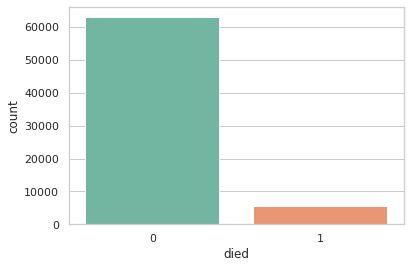

In [ ]:
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='died', data=df, palette='Set2')
plt.show()

Text(0.5, 1.0, 'NEWS1 > 5')

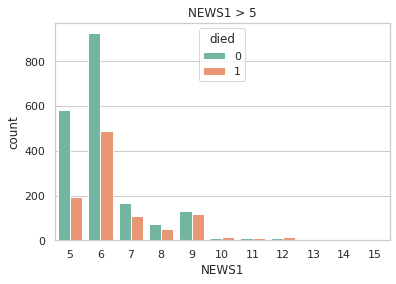

In [ ]:

df1= df.loc[df['NEWS1'] >= 5 ]
# df2= df.loc[df['NEWS'] > 5 ]

lm = sns.countplot(x='NEWS1',hue='died',data=df1,palette='Set2')
ax1 =lm.axes
ax1=plt.gca()
ax1.set_title('NEWS1 > 5')


Text(0.5, 1.0, 'NEWS2 >= 5')

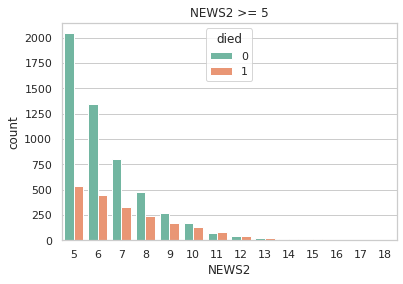

In [ ]:
df2= df.loc[df['NEWS2'] >= 5 ]

lm = sns.countplot(x='NEWS2',hue='died',data=df2,palette='Set2')
ax1 =lm.axes
ax1=plt.gca()
ax1.set_title('NEWS2 >= 5')

# Select Variables

In [ ]:
var1=['gender',	'age'	,'los','NEWS1','NEWS2','CARS']
variables = var1.copy()
variables.append('died')

**Heat map**

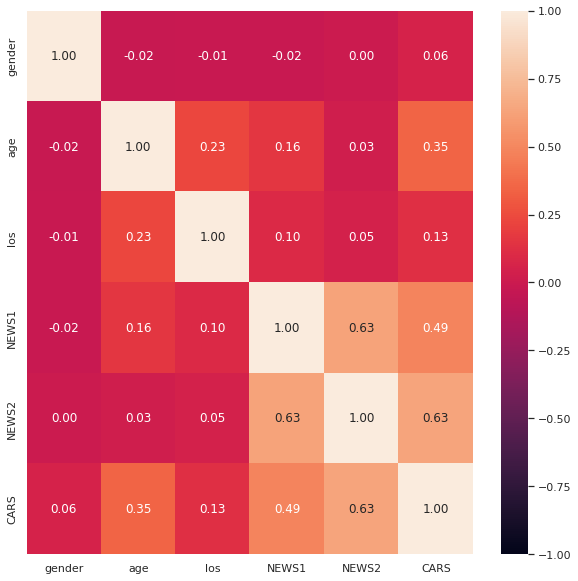

In [ ]:
corr = df[var1].corr()
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot = True,fmt = ".2f", vmin = -1.00, vmax = 1.00)

**Outliers**

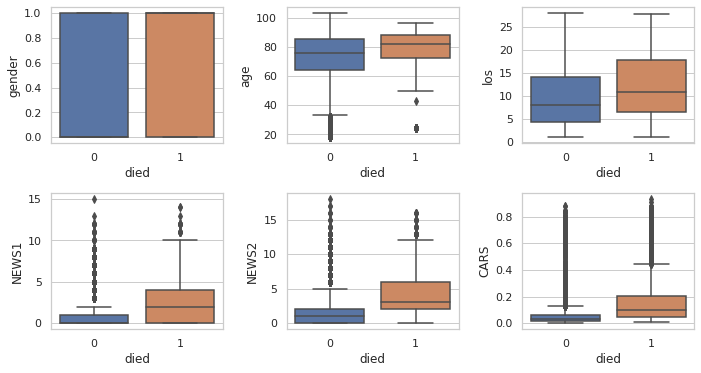

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
count = 0
for variable in var1:
    count += 1
    plt.subplot(4, 3, count)

    ax = sns.boxplot(x = 'died', y=variable, data=df)


fig.tight_layout()
plt.show()

In [ ]:
var=['los','NEWS1','subindex_n','submax_n','NEWS2']
variables = var.copy()
variables.append('died')

# Data preparation

As we take all the measurements against every unique ID. So, we need to summarize the feature for that apply feature construction to get one row against each ID.
Take the 'max', 'min', 'std', and 'mean' using the 'group by' function to aggregate data.


In [ ]:
def feature(data):
    data_max = df.groupby(['ID'])[var].max()
    data_max.columns = ['max ' + str(col) for col in data_max.columns]

    data_min = df.groupby(['ID'])[var].min()
    data_min.columns = ['min ' + str(col) for col in data_min.columns]

    data_std = df.groupby(['ID'])[var].std()
    data_std.columns = ['sd ' + str(col) for col in data_std.columns]

    data_mean = df.groupby(['ID'])[var].mean()
    data_mean.columns = ['mean ' + str(col) for col in data_mean.columns]

    data_agg = pd.concat([data_min,data_max,data_std,data_mean],axis=1)

    return data_agg

dt=feature(df).dropna(axis=0)
print('Extracted features: ')
display.display(dt.columns)
print('')
print('Total number of patient: '+str(dt.shape[0]))
print('Number of features: ' + str(dt.shape[1]))


Extracted features: 


Index(['min los', 'min NEWS1', 'min subindex_n', 'min submax_n', 'min NEWS2',
       'max los', 'max NEWS1', 'max subindex_n', 'max submax_n', 'max NEWS2',
       'sd los', 'sd NEWS1', 'sd subindex_n', 'sd submax_n', 'sd NEWS2',
       'mean los', 'mean NEWS1', 'mean subindex_n', 'mean submax_n',
       'mean NEWS2'],
      dtype='object')


Total number of patient: 1645
Number of features: 20


Now DataFrame containing one row per ID. Next, we are going to add the age and gender to the dataset.

In [ ]:
died = df.loc[dt.index]['died'].groupby(['ID']).max()
age = df.loc[dt.index]['age'].groupby(['ID']).max()
gender = df.loc[dt.index]['gender'].groupby(['ID']).max()

data_concat = pd.concat([dt, age, gender, died], axis=1).dropna(axis=0)
print('Total number of patient : ' + str(data_concat.shape[0]))
print('Number of features: ' + str(data_concat.shape[1]))

Total number of patient : 1645
Number of features: 23


# NEWS1

Divide the data into train and test sets

In [ ]:
from sklearn.model_selection import train_test_split
X=data_concat.drop(['died','min NEWS2','mean NEWS2', 'max NEWS2', 'sd NEWS2', ], axis='columns')
y=data_concat.died
# set the value for test set
test_size = 0.2

# Divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, random_state = 42)

In [ ]:
X_train.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame( scaler.fit_transform(X_train))
X_test =pd.DataFrame( scaler.fit_transform(X_test))

In [ ]:
X_train = np.array(X_train)
X_test=np.array(X_test)
x_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
x_train.shape

In [ ]:
X_test.shape

In [ ]:
print('Before reshape',X_train.shape)
print('After reshape',x_train.shape)

Before reshape (1316, 18)
After reshape (1316, 1, 18)


# MODEL

In [ ]:
lst = Sequential()

# input layer
lst.add(LSTM(units=50, return_sequences=True, input_shape=(1,x_train.shape[2])))
#output layer
lst.add(Dense(1, activation='sigmoid'))
# defining loss function, optimizer, metrics
lst.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
lst.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             13800     
                                                                 
 dense (Dense)               (None, 1, 1)              51        
                                                                 
Total params: 13,851
Trainable params: 13,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:

# training the model on training dataset
history_lst =lst.fit(x_train, y_train, epochs=30, batch_size=64,validation_split=0.2)

x_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

# predicting target attribute on testing dataset
test_results = lst.evaluate(x_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')


Epoch 1/30
17/17 [==============================] - 4s 69ms/step - loss: 0.6553 - accuracy: 0.7025 - val_loss: 0.6196 - val_accuracy: 0.8485
Epoch 2/30
17/17 [==============================] - 0s 12ms/step - loss: 0.5796 - accuracy: 0.8536 - val_loss: 0.5481 - val_accuracy: 0.8902
Epoch 3/30
17/17 [==============================] - 0s 10ms/step - loss: 0.5053 - accuracy: 0.8821 - val_loss: 0.4757 - val_accuracy: 0.8939
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4341 - accuracy: 0.9040 - val_loss: 0.4131 - val_accuracy: 0.9091
Epoch 5/30
17/17 [==============================] - 0s 10ms/step - loss: 0.3762 - accuracy: 0.9116 - val_loss: 0.3622 - val_accuracy: 0.9053
Epoch 6/30
17/17 [==============================] - 0s 15ms/step - loss: 0.3299 - accuracy: 0.9192 - val_loss: 0.3256 - val_accuracy: 0.9091
Epoch 7/30
17/17 [==============================] - 0s 10ms/step - loss: 0.2970 - accuracy: 0.9202 - val_loss: 0.2988 - val_accuracy: 0.9129
Epoch 8/30
17

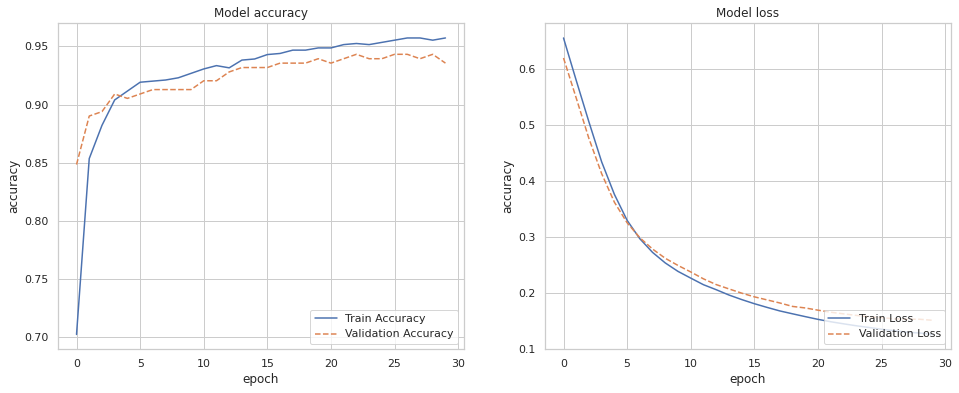

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history_lst.history['accuracy'])
axes[0].plot(history_lst.history['val_accuracy'],'--')
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')

axes[1].plot(history_lst.history['loss'])
axes[1].plot(history_lst.history['val_loss'],"--")
axes[1].set_title('Model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['Train Loss', 'Validation Loss'], loc='lower right')

In [ ]:
PD = lst.predict(x_test)
PD=PD.reshape(-1)


11/11 [==============================] - 1s 2ms/step


In [ ]:

from sklearn import metrics
news_fpr, news_tpr, thresholds = metrics.roc_curve( y_test, PD)
auc_news=metrics.auc(news_fpr, news_tpr)
print('ACU:',auc_news)


ACU: 0.8725199881551673


# NEWS2

In [ ]:
from sklearn.model_selection import train_test_split
X1=data_concat.drop(['died','min NEWS1','mean NEWS1','max NEWS1', 'sd NEWS1'], axis='columns')
y1=data_concat.died
# set the value for test set
test_size = 0.2

# Divide the data into train and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, test_size = test_size, random_state = 42)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X1_train = pd.DataFrame( scaler.fit_transform(X1_train))
X1_test =pd.DataFrame( scaler.fit_transform(X1_test))
X1_train = np.array(X1_train)
X1_test=np.array(X1_test)
x1_train = X1_train.reshape(X1_train.shape[0],1,X1_train.shape[1])
x1_train.shape

(1316, 1, 18)

In [ ]:
lst = Sequential() # initializing model

# input layer
lst.add(LSTM(units=50, return_sequences=True, input_shape=(1,x1_train.shape[2])))
# outpute layer
lst.add(Dense(1, activation='sigmoid'))
lst.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# training the model on training dataset
history_lst =lst.fit(x1_train, y1_train, epochs=30, batch_size=64,validation_split=0.2)

x1_test = X1_test.reshape(X1_test.shape[0],1,X1_test.shape[1])

# predicting target attribute on testing dataset
test_results = lst.evaluate(x1_test, y1_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

Epoch 1/30
17/17 [==============================] - 3s 41ms/step - loss: 0.6656 - accuracy: 0.7500 - val_loss: 0.6267 - val_accuracy: 0.8295
Epoch 2/30
17/17 [==============================] - 0s 6ms/step - loss: 0.5878 - accuracy: 0.8479 - val_loss: 0.5569 - val_accuracy: 0.8674
Epoch 3/30
17/17 [==============================] - 0s 7ms/step - loss: 0.5138 - accuracy: 0.8726 - val_loss: 0.4874 - val_accuracy: 0.8902
Epoch 4/30
17/17 [==============================] - 0s 7ms/step - loss: 0.4438 - accuracy: 0.9030 - val_loss: 0.4233 - val_accuracy: 0.8939
Epoch 5/30
17/17 [==============================] - 0s 7ms/step - loss: 0.3819 - accuracy: 0.9163 - val_loss: 0.3710 - val_accuracy: 0.8977
Epoch 6/30
17/17 [==============================] - 0s 7ms/step - loss: 0.3332 - accuracy: 0.9211 - val_loss: 0.3320 - val_accuracy: 0.9053
Epoch 7/30
17/17 [==============================] - 0s 7ms/step - loss: 0.2960 - accuracy: 0.9259 - val_loss: 0.3028 - val_accuracy: 0.9091
Epoch 8/30
17/17 [=

In [ ]:
PD1 = lst.predict(x1_test)
PD1=PD1.reshape(-1)

11/11 [==============================] - 1s 3ms/step


In [ ]:
news2_fpr, news2_tpr, thresholds = metrics.roc_curve( y1_test, PD1)
auc_news2 = metrics.auc(news2_fpr, news2_tpr)
print('ACU:',auc_news2)

ACU: 0.8540124370743263


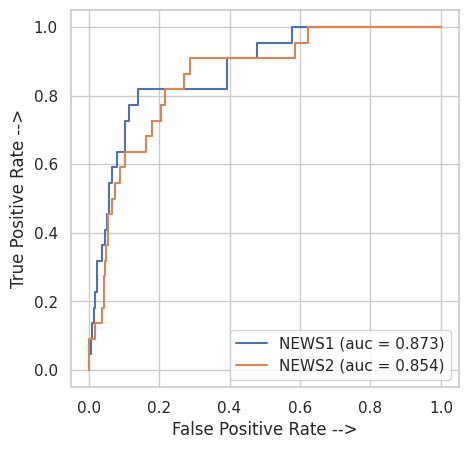

In [ ]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(news_fpr, news_tpr,  label='NEWS1 (auc = %0.3f)' % auc_news)
plt.plot(news2_fpr, news2_tpr, label='NEWS2 (auc = %0.3f)' % auc_news2)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()